In [1]:
import os
import json

import numpy as np
from tqdm import tqdm, trange

from scipy.spatial import cKDTree

import torch
from torch.optim import Adam
from torch.autograd import Function
from torch_geometric.data import Data, DataLoader

class PairwiseGraphBuilder:
    def __init__(self, X, locations, specimen=None, n_neighbors=10, node_meta = {}, edge_meta = {}):
        if isinstance(locations, torch.Tensor):
            locations = locations.cpu().numpy()
        if specimen is not None and isinstance(specimen, torch.Tensor):
            specimen = specimen.cpu().numpy()
        
        # Setup Data
        self.X = torch.tensor(X)
        self.locations = torch.tensor(locations)
        self.specimen = torch.tensor(specimen) if specimen is not None else None
        self.n_neighbors = n_neighbors
        self.ckd_tree = cKDTree(locations)

        self.node_meta = node_meta
        self.edge_meta = edge_meta

        # Compute nearest neighbors
        self._get_nearest_neighbors()

    def _get_nearest_neighbors(self):
        distances, indices = self.ckd_tree.query(self.locations, k=self.n_neighbors)
        self.indices = indices
        self.distances = distances
    
    def _fully_connected_graph(self, positions, include_self=True, device=None):
        if isinstance(positions, torch.Tensor):
            pos = positions
        else:
            pos = torch.tensor(positions, dtype=torch.float)

        N = pos.size(0)

        # Compute pairwise distance matrix
        dist_matrix = torch.cdist(pos, pos, p=2)  # (N, N)

        # Get all possible edges (i,j)
        src, dst = torch.meshgrid(
            torch.arange(N, device=pos.device),
            torch.arange(N, device=pos.device),
            indexing='ij'
        )

        # Optionally remove self-edges
        if not include_self:
            mask = src != dst
            src, dst = src[mask], dst[mask]
            edge_attr = dist_matrix[mask].unsqueeze(1)
        else:
            src, dst = src.reshape(-1), dst.reshape(-1)
            edge_attr = dist_matrix.reshape(-1, 1)

        edge_index = torch.stack([src, dst], dim=0)

        if device is not None:
            edge_index = edge_index.to(device)
            edge_attr = edge_attr.to(device)

        return edge_index, edge_attr
    
    def _construct_subgraph(self, index):
        # clone to avoid in-place edits
        X = self.X[self.indices[index]].clone()

        # Trying to avoid having the graph just pass information about the center node
        # Under global pooling conditions, I doubt it would ever actually leak in a 
        # due to the mixing that is going to go on, but I'm not going to risk that. I
        # also want to see if it would work if I only pass the center node's learned
        # embedding. 
        target = X[0]
        masked_X = X.clone()
        local_positions = self.locations[self.indices[index]]  # fixed typo
        edge_index, edge_attr = self._fully_connected_graph(local_positions)

        # I had some problems, now no more.
        assert edge_index.max() < X.size(0), "Edge indices exceed node count!"

        # Add specimen info if available
        if self.specimen is not None:
            specimen_label = self.specimen[self.indices[index]][0]
        else:
            specimen_label = -1

        data = Data(
            X=masked_X,
            edge_index=edge_index,
            edge_attr=edge_attr,
            target=target[None, :],
            specimen=specimen_label
        )

        for k, v in self.node_meta.items():
            data[k] = torch.tensor(v[self.indices[index]])
        for k, v in self.edge_meta.items():
            data[k] = torch.tensor(v[self.indices[index]])

        return data

    def create_dataloader(self, batch_size=64, shuffle=True):
        return DataLoader(
            [self._construct_subgraph(i) for i in trange(self.X.shape[0])],
            batch_size=batch_size,
            shuffle=shuffle
        )

In [4]:
import torch
import torch.nn as nn
from torch_geometric.nn import MessagePassing
from torch_geometric.utils import softmax

import torch
import torch.nn as nn
from torch_geometric.nn import MessagePassing
from torch_geometric.utils import softmax


class EdgeEmbeddingAttnConv(MessagePassing):
    def __init__(
        self,
        in_dim: int,
        out_dim: int,
        edge_dim: int = 16,
        hidden_dim: int = 128,
        aggr: str = "add",
        attn_dropout: float = 0.0,
    ):
        super().__init__(aggr=aggr)
        self.in_dim = in_dim
        self.out_dim = out_dim
        self.edge_dim = edge_dim

        # Node -> message value
        self.lin_v = nn.Linear(in_dim, out_dim, bias=False)

        # This is the "edge_mlp equivalent": produces an edge embedding per edge.
        self.edge_encoder = nn.Sequential(
            nn.Linear(2 * in_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, edge_dim),
        )

        # Use edge embedding to get attention logits (scalar per edge)
        self.attn_proj = nn.Linear(edge_dim, 1, bias=False)

        # Optional: use edge embedding to gate each message dimension (vector gate)
        self.gate_proj = nn.Linear(edge_dim, out_dim, bias=True)

        self.attn_dropout = nn.Dropout(attn_dropout)

        # For inspection
        self.last_alpha = None
        self.last_edge_emb = None

    def forward(self, x: torch.Tensor, edge_index: torch.Tensor):
        # propagate returns node updates; edge embeddings are stored for inspection
        out = self.propagate(edge_index=edge_index, x=x)
        return out

    def message(self, x_j, x_i, index, ptr, size_i):
        # Edge embedding e_ij: [E, edge_dim]
        e_ij = self.edge_encoder(torch.cat([x_j, x_i], dim=-1))
        self.last_edge_emb = e_ij.detach()

        # Attention weights alpha_ij: normalize over incoming edges of node i
        logits = self.attn_proj(e_ij).squeeze(-1)  # [E]
        alpha = softmax(logits, index, ptr, size_i)  # [E]
        alpha = self.attn_dropout(alpha)
        self.last_alpha = alpha.detach()

        # Message value + edge-conditioned gate
        v = self.lin_v(x_j)  # [E, out_dim]
        gate = torch.sigmoid(self.gate_proj(e_ij))  # [E, out_dim]

        return (v * gate) * alpha.unsqueeze(-1)



In [2]:
import numpy as np
import scanpy as sc
import pyro.distributions as dist

adata = sc.read_h5ad("/Users/jameshaberberger/Github/rapid-niches/adata-cell-leiden.h5ad")
adata = adata[adata.obs["folder"].eq("04-44")]

In [3]:

pgb = PairwiseGraphBuilder(
    adata.X,
    adata.obs[["x_centroid", "y_centroid"]].values, 
    specimen=adata.obs["folder"].cat.codes.values, 
    n_neighbors=10,
    node_meta = {
        "oro": torch.tensor(np.log1p(adata.obs["oil_red_o_area"]).values),
        "cell_type": torch.tensor(adata.obs["cell_type"].cat.codes),
        "niche_embedding": torch.tensor(adata.obsm["latent_representation"]),
        "cell_embedding": torch.tensor(adata.obsm["X_token"]),
        "counts": torch.tensor(adata.layers["transcript"])
    },
)

dataloader = pgb.create_dataloader(batch_size=256)

/var/folders/2n/j06nrn2n7r524t776sngh0xr0000gr/T/ipykernel_16509/2975677235.py:8: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  "cell_type": torch.tensor(adata.obs["cell_type"].cat.codes),
  0%|          | 0/37037 [00:00<?, ?it/s]/var/folders/2n/j06nrn2n7r524t776sngh0xr0000gr/T/ipykernel_16509/2833807056.py:106: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  data[k] = torch.tensor(v[self.indices[index]])
100%|██████████| 37037/37037 [00:08<00:00, 4495.44it/s]
/var/folders/2n/j06nrn2n7r524t776sngh0xr0000gr/T/ipykernel_16509/2833807056.py:113: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  return DataLoader(


In [61]:
eeac = EdgeEmbeddingAttnConv(adata.X.shape[1], out_dim=16)

In [62]:
decoder = nn.Sequential(
    nn.Linear(48, 128),
    nn.ReLU(),
    nn.Linear(128, 256),
    nn.ReLU(),
    nn.Linear(256, 366*3)
)

In [82]:
import pyro.distributions as dist

params = list(eeac.parameters()) + list(decoder.parameters())
optimizer = torch.optim.Adam(params, lr=1e-3, weight_decay=1e-4)

losses = []

for _ in range(10):
    pbar = tqdm(dataloader)
    for batch_data in pbar:
        optimizer.zero_grad(set_to_none=True)

        interaction_information = eeac(batch_data.X, batch_data.edge_index)[::10]
        message = torch.cat([
            batch_data.cell_embedding[::10],
            batch_data.niche_embedding[::10],
            interaction_information
        ], axis=1)
        estimated_parameters = decoder(message).reshape(-1, 3, 366)

        loss = -dist.ZeroInflatedDistribution(
            base_dist=dist.NegativeBinomial(
                total_count=estimated_parameters[:, 0, :].exp(),
                logits=estimated_parameters[:, 0, :],
            ),
            gate_logits=estimated_parameters[:, 0, :]
        ).log_prob(batch_data.counts[::10]).sum()

        pbar.set_postfix({"loss": loss.item()})

        losses.append(loss.item())
        loss.backward()
        optimizer.step()

  0%|          | 0/145 [00:00<?, ?it/s]/Users/jameshaberberger/GitHub/edge_embeddings/.venv/lib/python3.13/site-packages/torch_geometric/data/data.py:187: UserWarning:

Unable to accurately infer 'num_nodes' from the attribute set '{'edge_attr', 'specimen', 'counts', 'niche_embedding', 'X', 'cell_type', 'oro', 'cell_embedding', 'target', 'edge_index'}'. Please explicitly set 'num_nodes' as an attribute of 'data' to suppress this warning

/Users/jameshaberberger/GitHub/edge_embeddings/.venv/lib/python3.13/site-packages/torch_geometric/data/collate.py:142: UserWarning:

Unable to accurately infer 'num_nodes' from the attribute set '{'edge_attr', 'specimen', 'counts', 'niche_embedding', 'X', 'cell_type', 'oro', 'cell_embedding', 'target', 'edge_index'}'. Please explicitly set 'num_nodes' as an attribute of 'data' to suppress this warning

100%|██████████| 145/145 [00:05<00:00, 25.09it/s, loss=5.01e+4]


<Axes: >

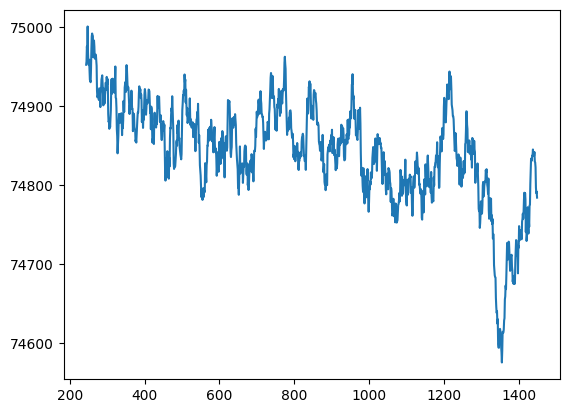

In [83]:
import pandas as pd
pd.Series(losses)[100:].rolling(145).mean().plot()

In [84]:
x0 = []
x1 = []
ct0 = []
ct1 = []
edge_embeddings = []

i = 0
for batch_data in tqdm(dataloader):
    if i%15 == 0:
        x0.append(batch_data.X[batch_data.edge_index][0])
        x1.append(batch_data.X[batch_data.edge_index][1])
        edge_embeddings.append(
            eeac.edge_encoder(
                batch_data.X[batch_data.edge_index].transpose(0, 1).reshape(batch_data.edge_index.shape[1], -1)
            )
        )
        ct0.append(batch_data.cell_type[batch_data.edge_index[0]])
        ct1.append(batch_data.cell_type[batch_data.edge_index[1]])
    i+=1

  0%|          | 0/145 [00:00<?, ?it/s]/Users/jameshaberberger/GitHub/edge_embeddings/.venv/lib/python3.13/site-packages/torch_geometric/data/data.py:187: UserWarning:

Unable to accurately infer 'num_nodes' from the attribute set '{'edge_attr', 'specimen', 'counts', 'niche_embedding', 'X', 'cell_type', 'oro', 'cell_embedding', 'target', 'edge_index'}'. Please explicitly set 'num_nodes' as an attribute of 'data' to suppress this warning

/Users/jameshaberberger/GitHub/edge_embeddings/.venv/lib/python3.13/site-packages/torch_geometric/data/collate.py:142: UserWarning:

Unable to accurately infer 'num_nodes' from the attribute set '{'edge_attr', 'specimen', 'counts', 'niche_embedding', 'X', 'cell_type', 'oro', 'cell_embedding', 'target', 'edge_index'}'. Please explicitly set 'num_nodes' as an attribute of 'data' to suppress this warning

100%|██████████| 145/145 [00:02<00:00, 52.77it/s]


In [85]:
ct0 = torch.cat(ct0)
ct1 = torch.cat(ct1)
x0 = torch.cat(x0)
x1 = torch.cat(x1)
edge_embeddings = torch.cat(edge_embeddings)

In [86]:
import umap
import numpy as np

X = edge_embeddings

reducer = umap.UMAP(
    n_neighbors=30,
    min_dist=0.1,
    n_components=2,
    random_state=None,
    n_jobs=-1
)

Z = reducer.fit_transform(
    X.detach().numpy()
)

In [87]:
import pandas as pd
import altair as alt
alt.data_transformers.enable("vegafusion")

table = pd.DataFrame(Z, columns=["x", "y"])

table = table.assign(cell_type_0=adata.obs['cell_type'].cat.categories[ct0])
table = table.assign(cell_type_1=adata.obs['cell_type'].cat.categories[ct1])

In [101]:
import pandas as pd
import plotly.express as px
import plotly.graph_objects as go
from IPython.display import display

# Build plotting DF (keep original index!)
df = (
    table.assign(expression=x1[:, 200])
         .copy()
)
df["idx"] = df.index  # stash original index

fig_px = px.scatter(
    df,
    x="x",
    y="y",
    color="cell_type_1",
    opacity=0.2,
    custom_data=["idx"],   # carries original index per point
    height=1000, 
    width=1000
)

fig = go.FigureWidget(fig_px)
fig.update_layout(dragmode="lasso")
fig.update_traces(marker=dict(size=3))

# These get updated on every selection
selected_idx = pd.Index([], dtype=df["idx"].dtype, name="selected_idx")
selected_df = df.iloc[0:0].copy()  # empty, same columns

def _on_selection(trace, points, selector):
    global selected_idx, selected_df

    all_selected = []
    for tr in fig.data:
        sp = tr.selectedpoints
        if sp:
            cd = tr.customdata
            all_selected.extend([cd[i][0] for i in sp])

    selected_idx = pd.Index(pd.unique(all_selected), name="selected_idx")
    # Optional: rows in the sampled df (not the full original table)
    selected_df = df.loc[selected_idx] if len(selected_idx) else df.iloc[0:0].copy()

for tr in fig.data:
    tr.on_selection(_on_selection)

display(fig)

# After lassoing, just use:
# selected_idx
# selected_df
# and to get the original table rows:
# table.loc[selected_idx]

FigureWidget({
    'data': [{'customdata': {'bdata': ('AAAAAAoAAAAUAAAAHgAAACgAAAAyAA' ... 'MA7ecDAPHnAwD25wMA9+cDAPvnAwA='),
                             'dtype': 'i4',
                             'shape': '42170, 1'},
              'hovertemplate': 'cell_type_1=Oligodendrocyte<br>x=%{x}<br>y=%{y}<extra></extra>',
              'legendgroup': 'Oligodendrocyte',
              'marker': {'color': '#636efa', 'opacity': 0.2, 'size': 3, 'symbol': 'circle'},
              'mode': 'markers',
              'name': 'Oligodendrocyte',
              'showlegend': True,
              'type': 'scattergl',
              'uid': '24d2556e-cc04-4015-b179-44220c5d4950',
              'x': {'bdata': ('RBBLQVVvFkFhEGRBxxFZQQTJTkGekl' ... 'xBhedEQUjrOUG8U4hA4e/wQIhXSEE='),
                    'dtype': 'f4'},
              'xaxis': 'x',
              'y': {'bdata': ('HVcTQedNEkD8FS5ARGfLQGFmQUGbW9' ... 'RA5J6/QEduRUGBJxzAEfH7vqqonEA='),
                    'dtype': 'f4'},
              'yaxis': 'y'},
    

In [ ]:
import sklearn.linear_model
table2 = pd.DataFrame()

for cell_type in adata.obs["cell_type"].unique():
    lm = sklearn.linear_model.Lasso(alpha=1e-3)
    y = np.zeros(x0.shape[0])
    y[selected_idx] = 1
    lm.fit(
    x0[table["cell_type_0"].eq(cell_type)], 
    y[table["cell_type_0"].eq(cell_type)]
    )
    table2[cell_type] = pd.Series(lm.coef_, index=adata.var.index).sort_values()

In [111]:
table2.max().sort_values()
cell_type = "Endothelial"
table2[cell_type].sort_values()

ABCC9      0.0
ABCG4      0.0
ACAT1      0.0
ACAT2      0.0
ACSL1      0.0
          ... 
VCAN       0.0
VIP        0.0
VWC2L      0.0
TMEM163    0.0
ZDHHC23    0.0
Name: Endothelial, Length: 366, dtype: float64

<Axes: xlabel='x', ylabel='y'>

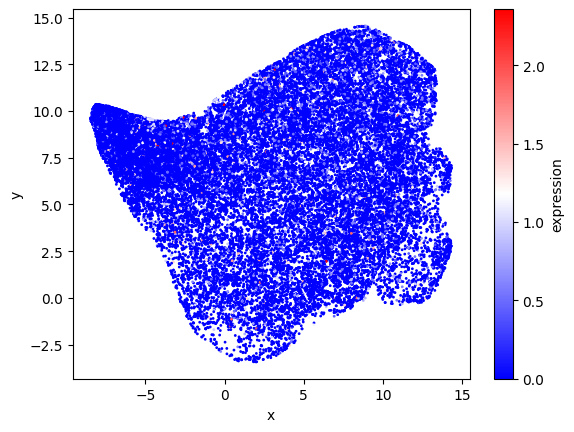

In [112]:
table.assign(expression=x0[:, (adata.var.index=="ITGB2").argmax()]).query("cell_type_0 == @cell_type").plot.scatter(
    x="x",
    y="y",
    c="expression",
    cmap="bwr",
    s=1
)